In [1]:
import pysam
from typing import List, Set, Dict, Tuple, Optional, NamedTuple
from pathlib import Path
from collections import defaultdict, Counter
from cyvcf2 import VCF, Variant
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
N = "N"

In [2]:
def is_diff(c1: str, c2: str) -> bool:
    return c1 != c2 and all(c != N for c in [c1, c2])

def diff_idxs(s1: str, s2: str) -> Set[int]:
    assert len(s1) == len(s2)
    return {i + 1 for i in range(len(s1)) if is_diff(s1[i], s2[i])}

class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1
    
    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)

In [3]:
REF = "mada_1-11"

We get the positions that differ between `REF` and the other samples. If either position has an `N` then we consider them not different.

In [4]:
pandora_reffa = pysam.FastaFile(f"pandora/{REF}.consensus.fa")
pandora_refseq = pandora_reffa.fetch(REF)

In [5]:
pandora_fasta_files = [p for p in Path("pandora").glob("*.fa") if REF not in p.name]

In [6]:
pandora_diff_positions: Dict[str, Set[int]] = dict()
for file in pandora_fasta_files:
    sample = file.name.split(".")[0]
    seq = pysam.FastaFile(file).fetch(sample)
    pandora_diff_positions[sample] = diff_idxs(pandora_refseq, seq)

In [7]:
for k, v in pandora_diff_positions.items():
    print(f"{k}: {len(v)} dist.")

mada_1-28: 157 dist.
mada_115: 155 dist.
mada_2-42: 149 dist.
mada_142: 147 dist.
mada_125: 157 dist.
mada_1-8: 159 dist.


Now that we have the positions, we gather the VCF entries for those positions

In [8]:
pandora_refvcf = VCF(f"pandora/{REF}.snps.filtered.bcf")

pandora_vcf_files = [p for p in Path("pandora").glob("*.bcf") if REF not in p.name]

pandora_diff_vars: Dict[str, List[Tuple[Optional[Variant], Optional[Variant]]]] = defaultdict(list)
chrom = pandora_refvcf.seqnames[0]
for file in pandora_vcf_files:
    sample = file.name.split(".")[0]
    idxs = pandora_diff_positions[sample]
    vcf = VCF(file)
    for i in idxs:
        region = f"{chrom}:{i}-{i}"
        try:
            v = next(vcf(region))
        except StopIteration:
            v = None
        try:
            rv = next(pandora_refvcf(region))
        except StopIteration:
            rv = None
        pandora_diff_vars[sample].append((v, rv))

Get compass "truth" positions

In [9]:
compass_reffa = pysam.FastaFile(f"compass/{REF}.consensus.fa")
compass_refseq = compass_reffa.fetch(REF)

In [10]:
compass_fasta_files = [p for p in Path("compass").glob("*.fa") if REF not in p.name]

In [11]:
compass_diff_positions: Dict[str, Set[int]] = dict()
for file in compass_fasta_files:
    sample = file.name.split(".")[0]
    seq = pysam.FastaFile(file).fetch(sample)
    compass_diff_positions[sample] = diff_idxs(compass_refseq, seq)

In [12]:
for k, v in compass_diff_positions.items():
    print(f"{k}: {len(v)} dist.")

mada_1-28: 9 dist.
mada_115: 6 dist.
mada_2-42: 15 dist.
mada_142: 8 dist.
mada_125: 8 dist.
mada_1-8: 12 dist.


Get compass "truth" difference variants

In [13]:
compass_refvcf = VCF(f"compass/{REF}.compass.bcf")

compass_vcf_files = [p for p in Path("compass").glob("*.bcf") if REF not in p.name]

compass_diff_vars: Dict[str, List[Tuple[Optional[Variant], Optional[Variant]]]] = defaultdict(list)
chrom = compass_refvcf.seqnames[0]
for file in compass_vcf_files:
    sample = file.name.split(".")[0]
    idxs = compass_diff_positions[sample]
    vcf = VCF(file)
    for i in idxs:
        region = f"{chrom}:{i}-{i}"
        try:
            v = next(vcf(region))
        except StopIteration:
            v = None
        try:
            rv = next(compass_refvcf(region))
        except StopIteration:
            rv = None
        compass_diff_vars[sample].append((v, rv))

Before we go any further, lets take a look at the distance between the pandora and compass consensus sequnces for `REF`

In [14]:
ref_diff_idxs = diff_idxs(pandora_refseq, compass_refseq)

In [15]:
print(f"{REF} pandora x compass dist: {len(ref_diff_idxs)}")

mada_1-11 pandora x compass dist: 79


Lets see how many of those positions are in the differences between `REF` and the other samples

In [16]:
for sample, diff_positions in pandora_diff_positions.items():
    in_both = diff_positions & ref_diff_idxs
    print(f"{sample}: {len(in_both)/len(diff_positions)*100:.2f}% of positions are in the differences between pandora and compass")

mada_1-28: 4.46% of positions are in the differences between pandora and compass
mada_115: 3.87% of positions are in the differences between pandora and compass
mada_2-42: 3.36% of positions are in the differences between pandora and compass
mada_142: 0.68% of positions are in the differences between pandora and compass
mada_125: 3.18% of positions are in the differences between pandora and compass
mada_1-8: 3.77% of positions are in the differences between pandora and compass


Lets also look at what the number of differences between pandora and compass for the other samples

In [17]:
caller_diff_positions: Dict[str, Set[int]] = dict()
for sample in compass_diff_vars:
    pseq = pysam.FastaFile(f"pandora/{sample}.consensus.fa").fetch(sample)
    cseq = pysam.FastaFile(f"compass/{sample}.consensus.fa").fetch(sample)
    caller_diff_positions[sample] = diff_idxs(cseq, pseq)

In [18]:
for k, v in caller_diff_positions.items():
    print(f"{k}: {len(v)} dist.")

mada_2-42: 93 dist.
mada_115: 93 dist.
mada_1-8: 75 dist.
mada_1-28: 92 dist.
mada_142: 85 dist.
mada_125: 89 dist.


Ok, so the difference of 79 between `mada_1-11` for the two callers seems "reasonable"

Lets take a look at how many of the compass differences pandora called.

In [19]:
for sample, cposs in compass_diff_positions.items():
    pposs = pandora_diff_positions[sample]
    in_both = cposs & pposs
    perc = len(in_both)/len(cposs)
    print(f"{sample}: {len(in_both)}/{len(cposs)} ({perc:.2%}) truth positions called by pandora")

mada_1-28: 7/9 (77.78%) truth positions called by pandora
mada_115: 5/6 (83.33%) truth positions called by pandora
mada_2-42: 11/15 (73.33%) truth positions called by pandora
mada_142: 6/8 (75.00%) truth positions called by pandora
mada_125: 5/8 (62.50%) truth positions called by pandora
mada_1-8: 7/12 (58.33%) truth positions called by pandora


Organise the difference positions into classification categorys:
- TP is a difference that pandora has called that compass also called
- FP is a difference that pandora had called that compass did not call
- FN is a difference that compass called that we did not

In [20]:
pos_data = []
for sample, pposs in pandora_diff_positions.items():
    cposs = compass_diff_positions[sample]
    tps = cposs & pposs
    fps = pposs - cposs
    fns = cposs - pposs
    for p in tps:
        pos_data.append((sample, p, "TP"))
    for p in fps:
        pos_data.append((sample, p, "FP"))
    for p in fns:
        pos_data.append((sample, p, "FN"))
df = pd.DataFrame(pos_data, columns=["sample", "pos", "classification"])

How many of the false positives are shared across multiple pairs?

In [21]:
fp_df = df.query("classification == 'FP'")
sizes = fp_df.groupby("pos").size()

In [22]:
num_fps = len(sizes)
for i in range(len(pandora_diff_positions)):
    l = len(sizes.where(sizes == i+1).dropna())
    print(f"{l} ({l/num_fps:.2%}) FP positions occur in {i+1} pairs")

21 (11.86%) FP positions occur in 1 pairs
4 (2.26%) FP positions occur in 2 pairs
8 (4.52%) FP positions occur in 3 pairs
5 (2.82%) FP positions occur in 4 pairs
24 (13.56%) FP positions occur in 5 pairs
115 (64.97%) FP positions occur in 6 pairs


In [23]:
fps_shared_all = set(sizes.where(sizes == 6).dropna().index)

How many of the false positive positions are missing from the `mada_1-11` pandora VCF? i.e. we assume REF in the consensus sequence for `mada_1-11`.

In [24]:
def pos_in_vcf(pos: int, vcf: VCF, chrom: str) -> bool:
    return next(vcf(f"{chrom}:{pos}-{pos}"), None) is not None

In [25]:
fp_poss = set(fp_df["pos"])

In [26]:
fps_in_ref = set()
fps_not_in_ref = set()
for pos in fp_poss:
    if pos_in_vcf(pos, pandora_refvcf, chrom):
        fps_in_ref.add(pos)
    else:
        fps_not_in_ref.add(pos)

In [27]:
print(f"{len(fps_in_ref)} FPs are in {REF}")
print(f"{len(fps_not_in_ref)} FPs are not in {REF}")

81 FPs are in mada_1-11
96 FPs are not in mada_1-11


In [28]:
for sample, variants in pandora_diff_vars.items():
    missing = 0
    n = 0
    for v, rv in variants:
        pos = v.POS if v is not None else rv.POS
        if pos not in fp_poss:
            continue
        if rv is None or v is None:
            missing += 1
        n += 1
    print(f"{sample}: {missing}/{n} ({missing/n:.2%}) FPs are due to one sample missing a position")

mada_1-28: 84/148 (56.76%) FPs are due to one sample missing a position
mada_125: 87/151 (57.62%) FPs are due to one sample missing a position
mada_115: 84/149 (56.38%) FPs are due to one sample missing a position
mada_1-8: 85/150 (56.67%) FPs are due to one sample missing a position
mada_2-42: 73/137 (53.28%) FPs are due to one sample missing a position
mada_142: 75/140 (53.57%) FPs are due to one sample missing a position


What do we say at false negative positions?

In [29]:
fn_df = df.query("classification == 'FN'")

In [30]:
for idx, row in fn_df.iterrows():
    vcf = VCF(f"pandora/{row['sample']}.snps.filtered.bcf")
    v = next(vcf(f"{chrom}:{row.pos}:{row.pos}"), None)
    rv = next(pandora_refvcf(f"{chrom}:{row.pos}:{row.pos}"), None)
    print(f"{sample} x {REF} FN at position {row.pos}")
    print(f"{sample}: {str(v)}")
    print(f"{REF}: {str(rv)}")

mada_142 x mada_1-11 FN at position 3901414
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 499855
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 499855
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 3970728
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 499855
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 3794956
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 3241591
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 621331
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 499855
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 4400515
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 1663869
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 499855
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at position 2895842
mada_142: None
mada_1-11: None
mada_142 x mada_1-11 FN at posi

no intervals found for b'pandora/mada_1-28.snps.filtered.bcf' at NC_000962.3:3901414:3901414
no intervals found for b'pandora/mada_1-11.snps.filtered.bcf' at NC_000962.3:3901414:3901414
no intervals found for b'pandora/mada_1-28.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_1-11.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_115.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_1-11.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_2-42.snps.filtered.bcf' at NC_000962.3:3970728:3970728
no intervals found for b'pandora/mada_1-11.snps.filtered.bcf' at NC_000962.3:3970728:3970728
no intervals found for b'pandora/mada_2-42.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_1-11.snps.filtered.bcf' at NC_000962.3:499855:499855
no intervals found for b'pandora/mada_2-42.snps.filtered.bcf' at NC_000962.3:379495

So we can see that all FN positions did not occur in any of our VCFs.

What does compass say at the false positive positions?

In [31]:
pandora_fp_bases = []
compass_fp_bases = []

for _, row in fp_df.iterrows():
    pos = row["pos"]
    sample = row["sample"]
    c = pysam.FastaFile(f"pandora/{sample}.consensus.fa").fetch(sample)[pos-1]
    refc = pandora_refseq[pos-1]
#     print(f"{pos}:{sample} pandora: {c}\t{refc}")
    pandora_fp_bases.append((c, refc, pos, sample))
    c = pysam.FastaFile(f"compass/{sample}.consensus.fa").fetch(sample)[pos-1]
    refc = compass_refseq[pos-1]
#     print(f"{pos}:{sample} compass: {c}\t{refc}")
    compass_fp_bases.append((c, refc))

In [32]:
ns = 0
for i in range(len(pandora_fp_bases)):
    if N in compass_fp_bases[i]:
        ns += 1
perc = ns / len(compass_fp_bases)
print(f"For {ns}/{len(compass_fp_bases)} ({perc:.2%}) FP positions, one of the compass bases is an '{N}'")

For 832/883 (94.22%) FP positions, one of the compass bases is an 'N'


Let's see what the nullified base was due to (i.e. filter, het, missing, or null call) *Note: it can't be mask as it would have been masked in pandora too*

In [33]:
reasons = []
filters = []
for i in range(len(pandora_fp_bases)):
    _, _, pos, sample = pandora_fp_bases[i]
    region = f"{chrom}:{pos}-{pos}"
    rv = next(compass_refvcf(region), None)
    vcf = VCF(f"compass/{sample}.compass.bcf")
    v = next(vcf(region), None)
    if v is None or rv is None:
        reasons.append("MISSING")
        continue
    if (vfilt := v.FILTER) or (rvfilt := rv.FILTER):
        reasons.append("FILTER")
        if vfilt is not None:
            filters.extend(vfilt.split(";"))
        if rvfilt is not None:
            filters.extend(rvfilt.split(";"))
        continue
    gt = Genotype.from_arr(v.genotypes[0])
    gt_ref = Genotype.from_arr(rv.genotypes[0])
    if gt.is_null() or gt_ref.is_null():
        reasons.append("NULL")
        continue
    if gt.is_het() or gt_ref.is_het():
        reasons.append("HET")
        continue
    if gt.is_hom_ref():
        reasons.append("REF")
        continue
    if gt.is_hom_alt():
        reasons.append("ALT")
        continue
    raise NotImplementedError(i)

In [34]:
for k, count in Counter(reasons).items():
    print(f"{k}:\t{count} ({count/len(fp_df):.2%})")

FILTER:	832 (94.22%)
ALT:	38 (4.30%)
REF:	13 (1.47%)


So, 94% FPs are filtered calls in compass...

What type of filters is COMPASS using?

In [35]:
Counter(filters)

Counter({'K0.90': 839, 'z': 839, 'f0.35': 1, 'S25': 5, 'n5': 1})

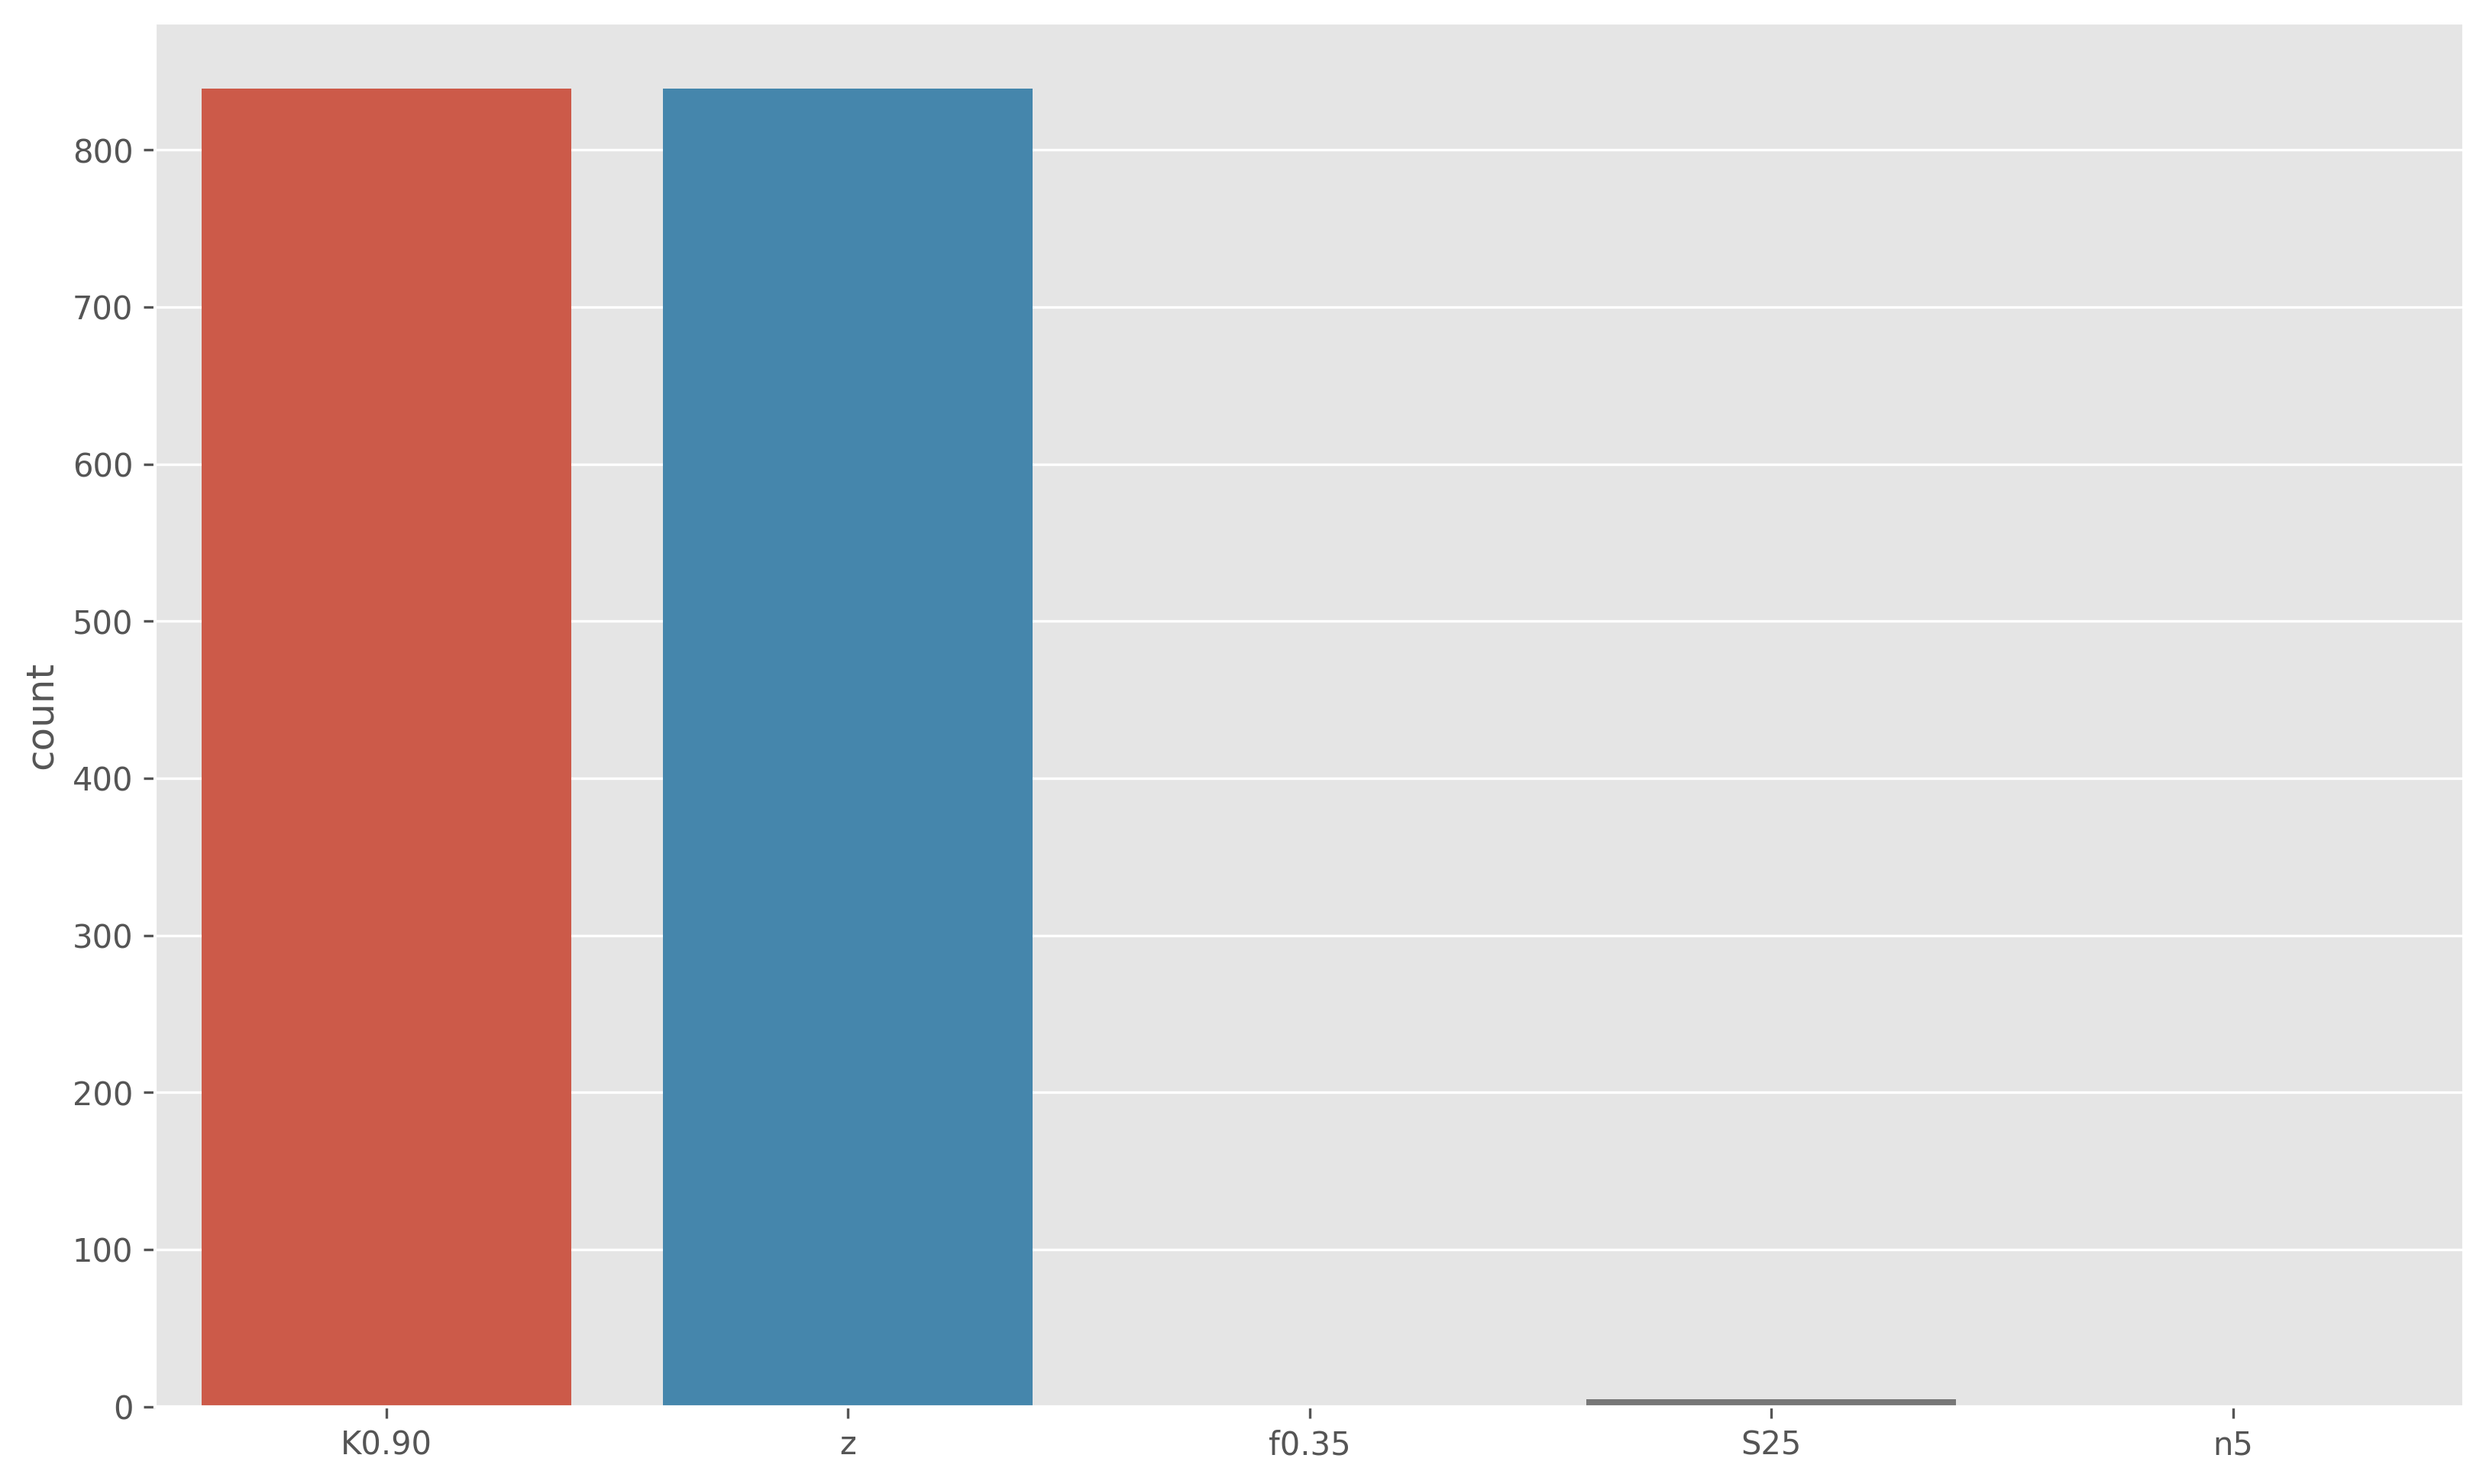

In [36]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.countplot(x=filters)

The meanings of these filters is
- `K0.90`: Base not called because proportion of the high-quality bases that supports the BCALL base call < 0.90
- `z`: Base not called because SAMtools made an initial heterozygote call (genotype X/Y where X!=Y)
- `f0.35`: Base not called because proportion of the high-quality mapped bases sum(BaseCounts4) < 0.35 of total spanning reads DP
- `S25`: Base not called because min SNP quality less than 25
- `n5`: Base not called because number of high quality bases at this position < 5

What are the GT_CONF scores for the FPs?

In [37]:
gtconfs = []
for i in range(len(pandora_fp_bases)):
    _, _, pos, sample = pandora_fp_bases[i]
    region = f"{chrom}:{pos}-{pos}"
    rv = next(pandora_refvcf(region), None)
    vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
    v = next(vcf(region), None)
    if v is None:
        gtconfs.append((rv.format("GT_CONF")[0][0], "FP"))
        continue
    if rv is None:
        gtconfs.append((v.format("GT_CONF")[0][0], "FP"))
        continue
    gtconfs.append((rv.format("GT_CONF")[0][0], "FP"))
    gtconfs.append((v.format("GT_CONF")[0][0], "FP"))

In [38]:
for sample in pandora_diff_positions:
    for variant in VCF(f"pandora/{sample}.snps.filtered.bcf"):
        if variant.POS in fp_poss or variant.FILTER:
            continue
        gtconfs.append((variant.format("GT_CONF")[0][0], "OTHER"))
for variant in VCF(f"pandora/{REF}.snps.filtered.bcf"):
    if variant.POS in fp_poss or variant.FILTER:
        continue
    gtconfs.append((variant.format("GT_CONF")[0][0], "OTHER"))

In [39]:
gtdf = pd.DataFrame(gtconfs, columns=["gt_conf", "class"]).query("gt_conf < 700")

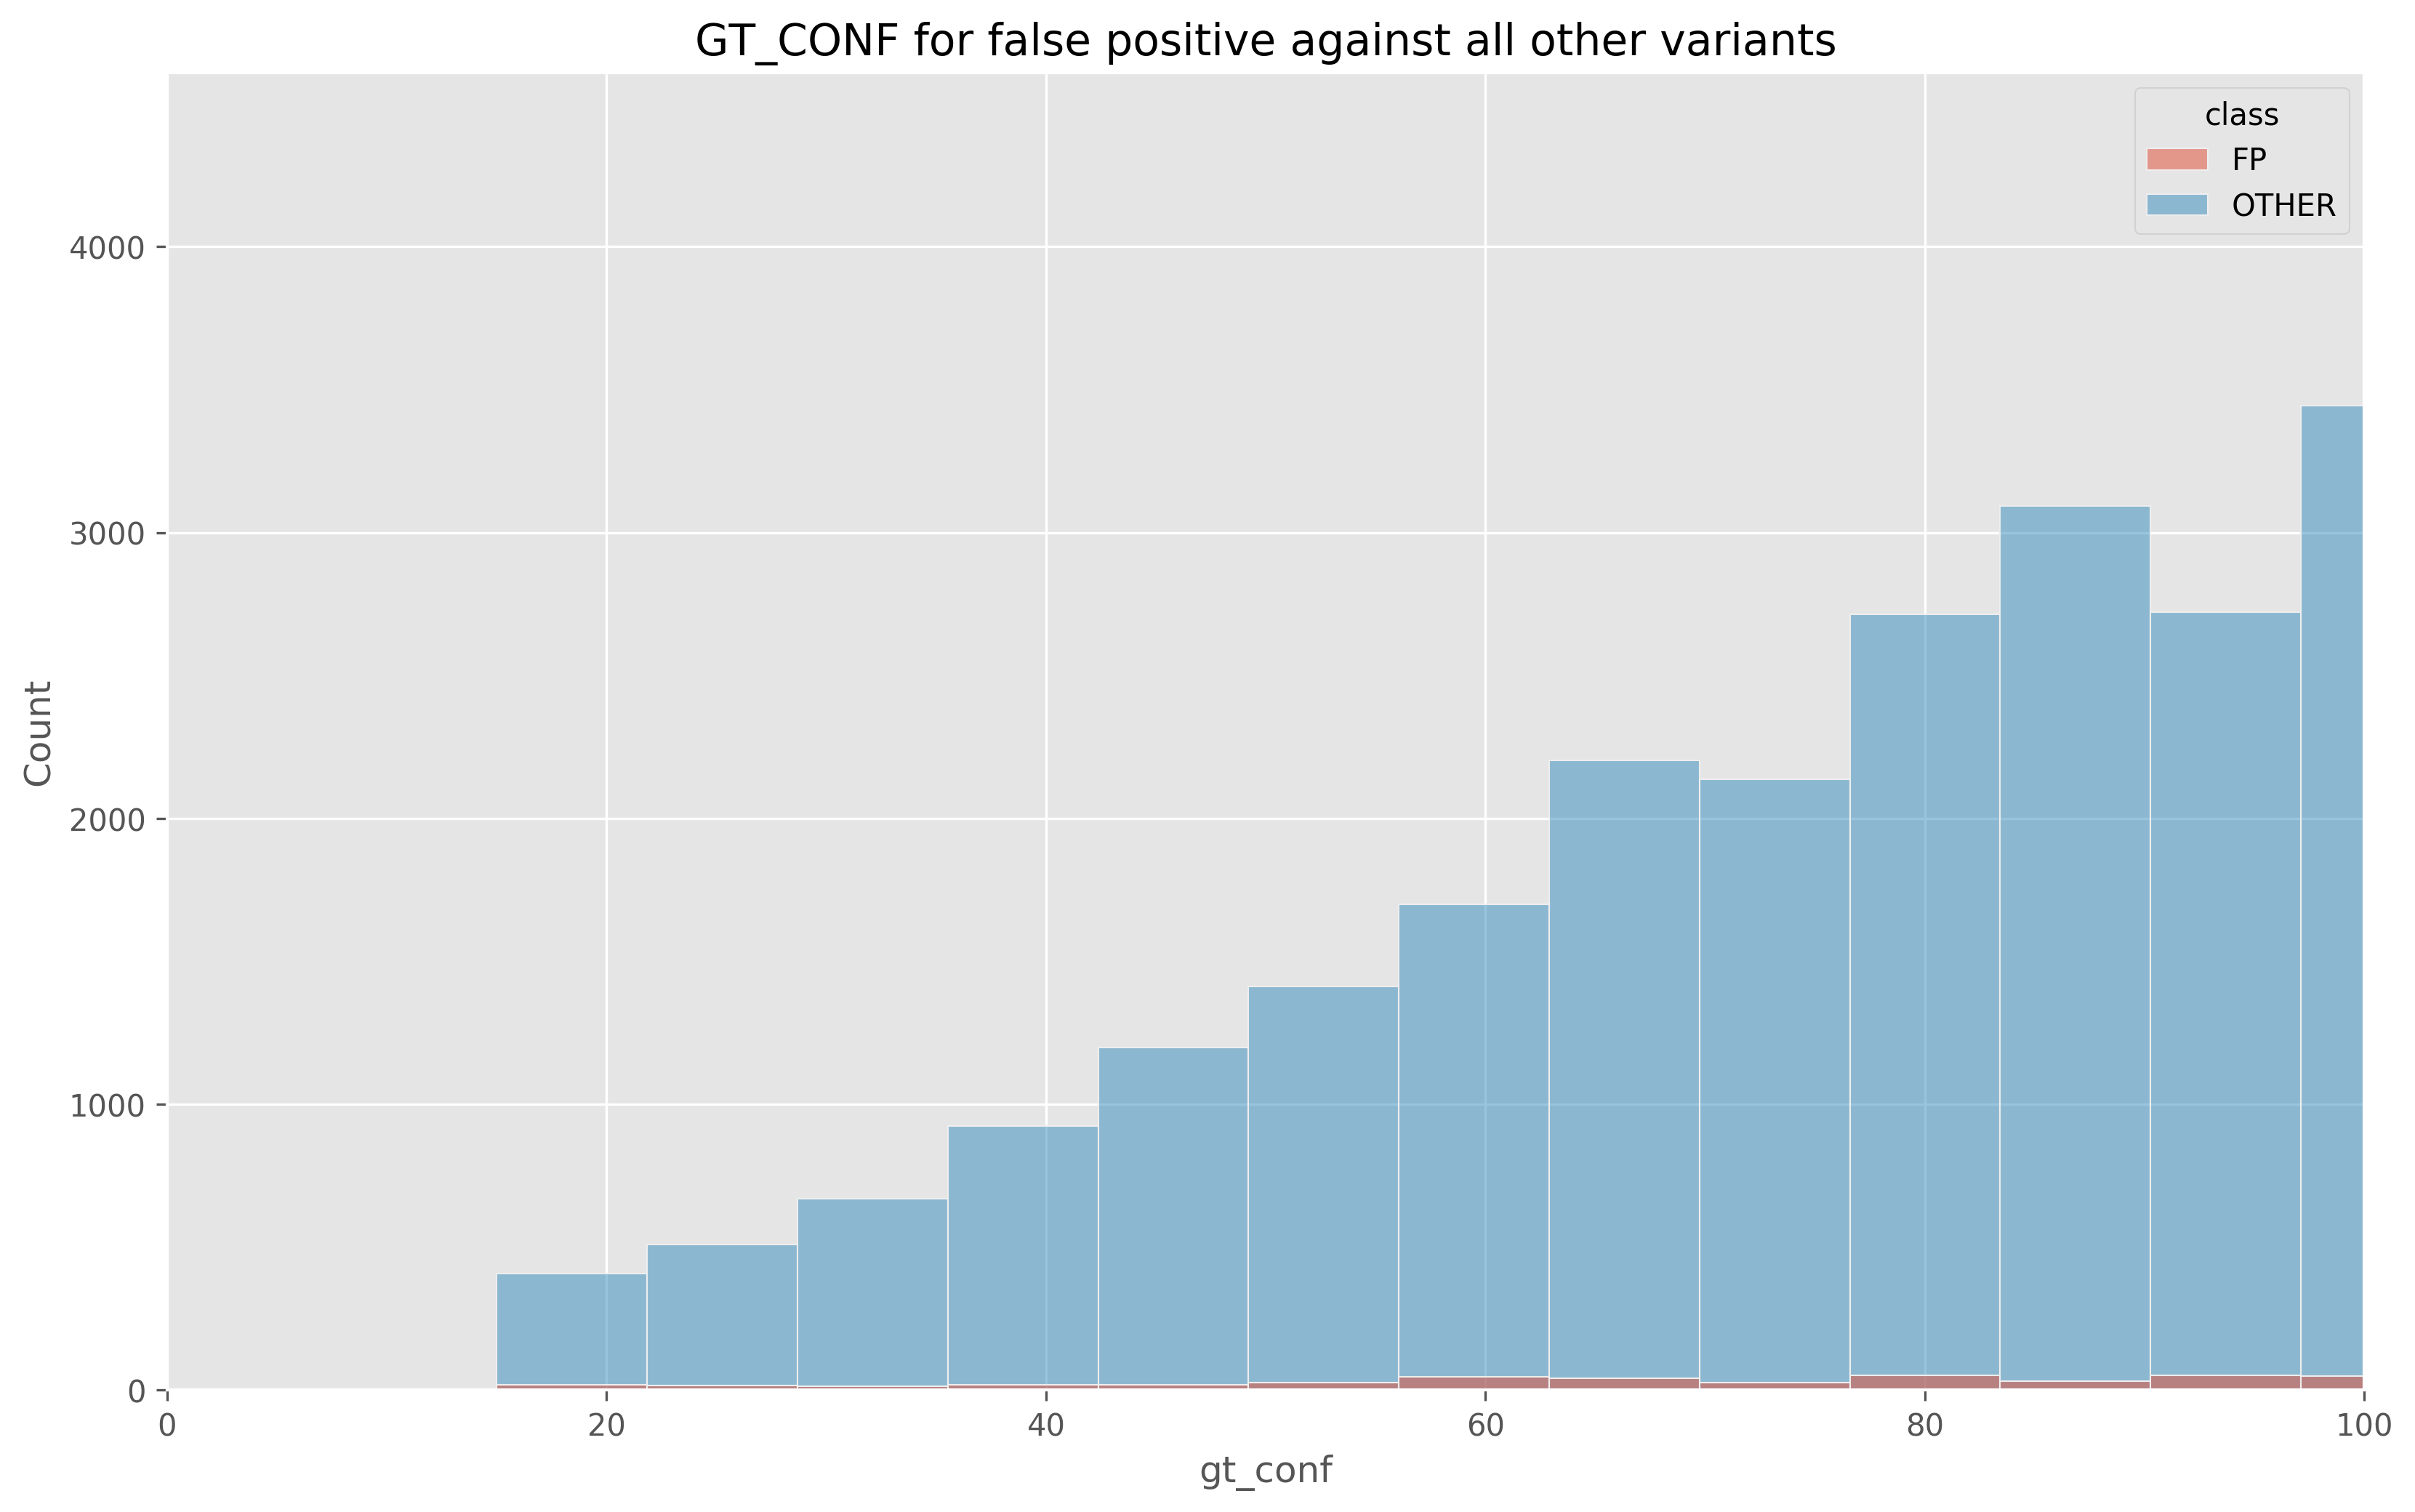

In [40]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=gtdf, x="gt_conf", hue="class", bins=100,)
ax.set_xlim((0, 100))
_ = ax.set(title="GT_CONF for false positive against all other variants")

Looking at the gaps values in FPs

In [41]:
def get_gaps(variant : Variant) -> float:
    gt = Genotype.from_arr(variant.genotypes[0])
    idx = gt.allele_index()
    return variant.format("GAPS")[0][idx]

In [42]:
gaps_data = []
for i in range(len(pandora_fp_bases)):
    _, _, pos, sample = pandora_fp_bases[i]
    region = f"{chrom}:{pos}-{pos}"
    rv = next(pandora_refvcf(region), None)
    vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
    v = next(vcf(region), None)
    if v is None:
        gaps_data.append((get_gaps(rv), "FP"))
        continue
    if rv is None:
        gaps_data.append((get_gaps(v), "FP"))
        continue
    gaps_data.append((get_gaps(rv), "FP"))
    gaps_data.append((get_gaps(v), "FP"))
    
for sample in pandora_diff_positions:
    for variant in VCF(f"pandora/{sample}.snps.filtered.bcf"):
        if variant.POS in fp_poss or variant.FILTER:
            continue
        gaps_data.append((get_gaps(variant), "OTHER"))
for variant in VCF(f"pandora/{REF}.snps.filtered.bcf"):
    if variant.POS in fp_poss or variant.FILTER:
        continue
    gaps_data.append((get_gaps(variant), "OTHER"))
    
gaps_df = pd.DataFrame(gaps_data, columns=["gaps", "class"])

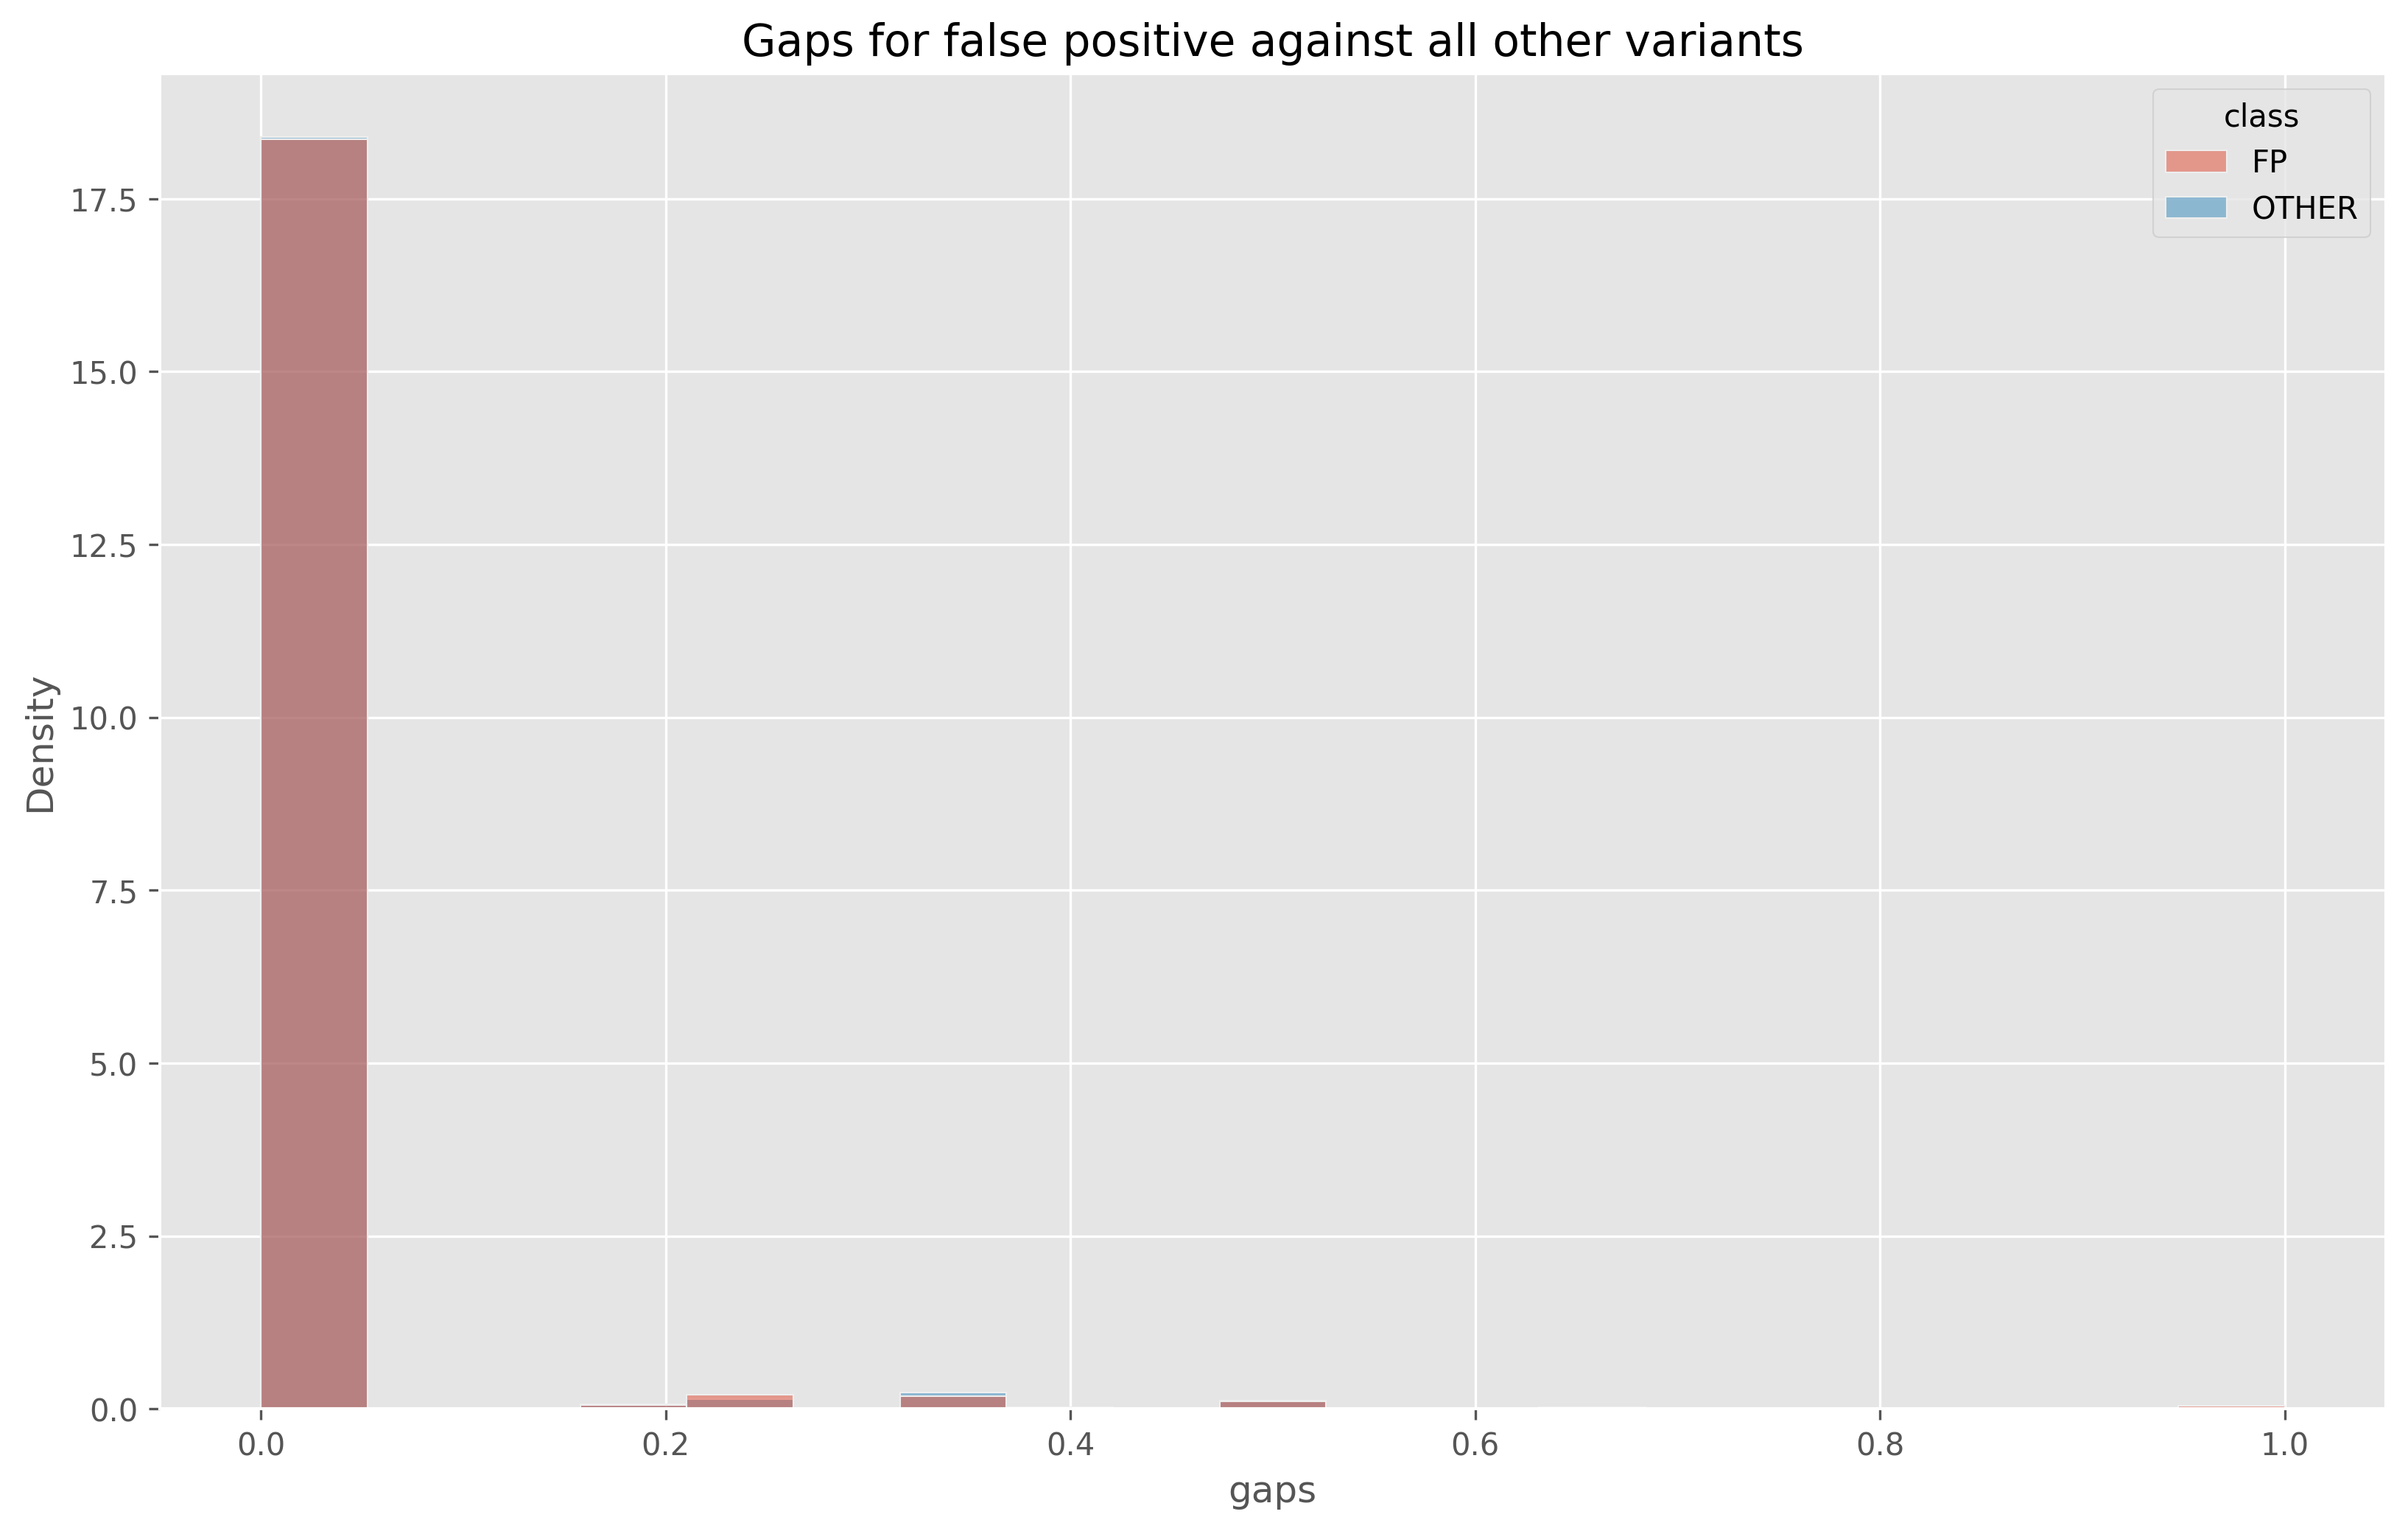

In [43]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=gaps_df, x="gaps", hue="class", common_norm=False, stat="density")
# ax.set_xlim((0.1, 1))
# ax.set_ylim((0, 2000))
_ = ax.set(title="Gaps for false positive against all other variants")

Let's look at coverage

In [53]:
from dataclasses import dataclass
from enum import Enum

class Tags(Enum):
    FwdCovg = "MED_FWD_COVG"
    RevCovg = "MED_REV_COVG"
    LowCovg = "ld"
    HighCovg = "hd"
    StrandBias = "sb"
    Gaps = "GAPS"
    HighGaps = "hg"
    GtypeConf = "GT_CONF"
    LowGtConf = "lgc"
    LongIndel = "lindel"
    Pass = "PASS"
    FormatFilter = "FT"
    AllFail = "FAIL"

    def __str__(self) -> str:
        return str(self.value)

@dataclass
class Strand:
    forward_covg: int = 0
    reverse_covg: int = 0

    @property
    def ratio(self) -> float:
        try:
            return min(self.covgs) / sum(self.covgs)
        except ZeroDivisionError:
            return 1.0

    @property
    def covgs(self) -> Tuple[int, int]:
        return self.forward_covg, self.reverse_covg

    @staticmethod
    def from_variant(variant: Variant, sample_idx: int = 0) -> "Strand":
        gt_idx = Genotype.from_arr(variant.genotypes[sample_idx]).allele_index()
        fwd_covg = variant.format(Tags.FwdCovg.value)[sample_idx][gt_idx]
        rev_covg = variant.format(Tags.RevCovg.value)[sample_idx][gt_idx]

        return Strand(fwd_covg, rev_covg)
    
def get_covg(variant: Variant, sample_idx: int = 0) -> int:
    strand = Strand.from_variant(variant, sample_idx=sample_idx)
    return sum(strand.covgs)

In [45]:
covg_data = []
for i in range(len(pandora_fp_bases)):
    _, _, pos, sample = pandora_fp_bases[i]
    region = f"{chrom}:{pos}-{pos}"
    rv = next(pandora_refvcf(region), None)
    vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
    v = next(vcf(region), None)
    if v is None:
        covg_data.append((get_covg(rv), "FP"))
        continue
    if rv is None:
        covg_data.append((get_covg(v), "FP"))
        continue
    covg_data.append((get_covg(rv), "FP"))
    covg_data.append((get_covg(v), "FP"))
    
for sample in pandora_diff_positions:
    for variant in VCF(f"pandora/{sample}.snps.filtered.bcf"):
        if variant.POS in fp_poss or variant.FILTER:
            continue
        covg_data.append((get_covg(variant), "OTHER"))
for variant in VCF(f"pandora/{REF}.snps.filtered.bcf"):
    if variant.POS in fp_poss or variant.FILTER:
        continue
    covg_data.append((get_covg(variant), "OTHER"))
    
covg_df = pd.DataFrame(covg_data, columns=["covg", "class"])

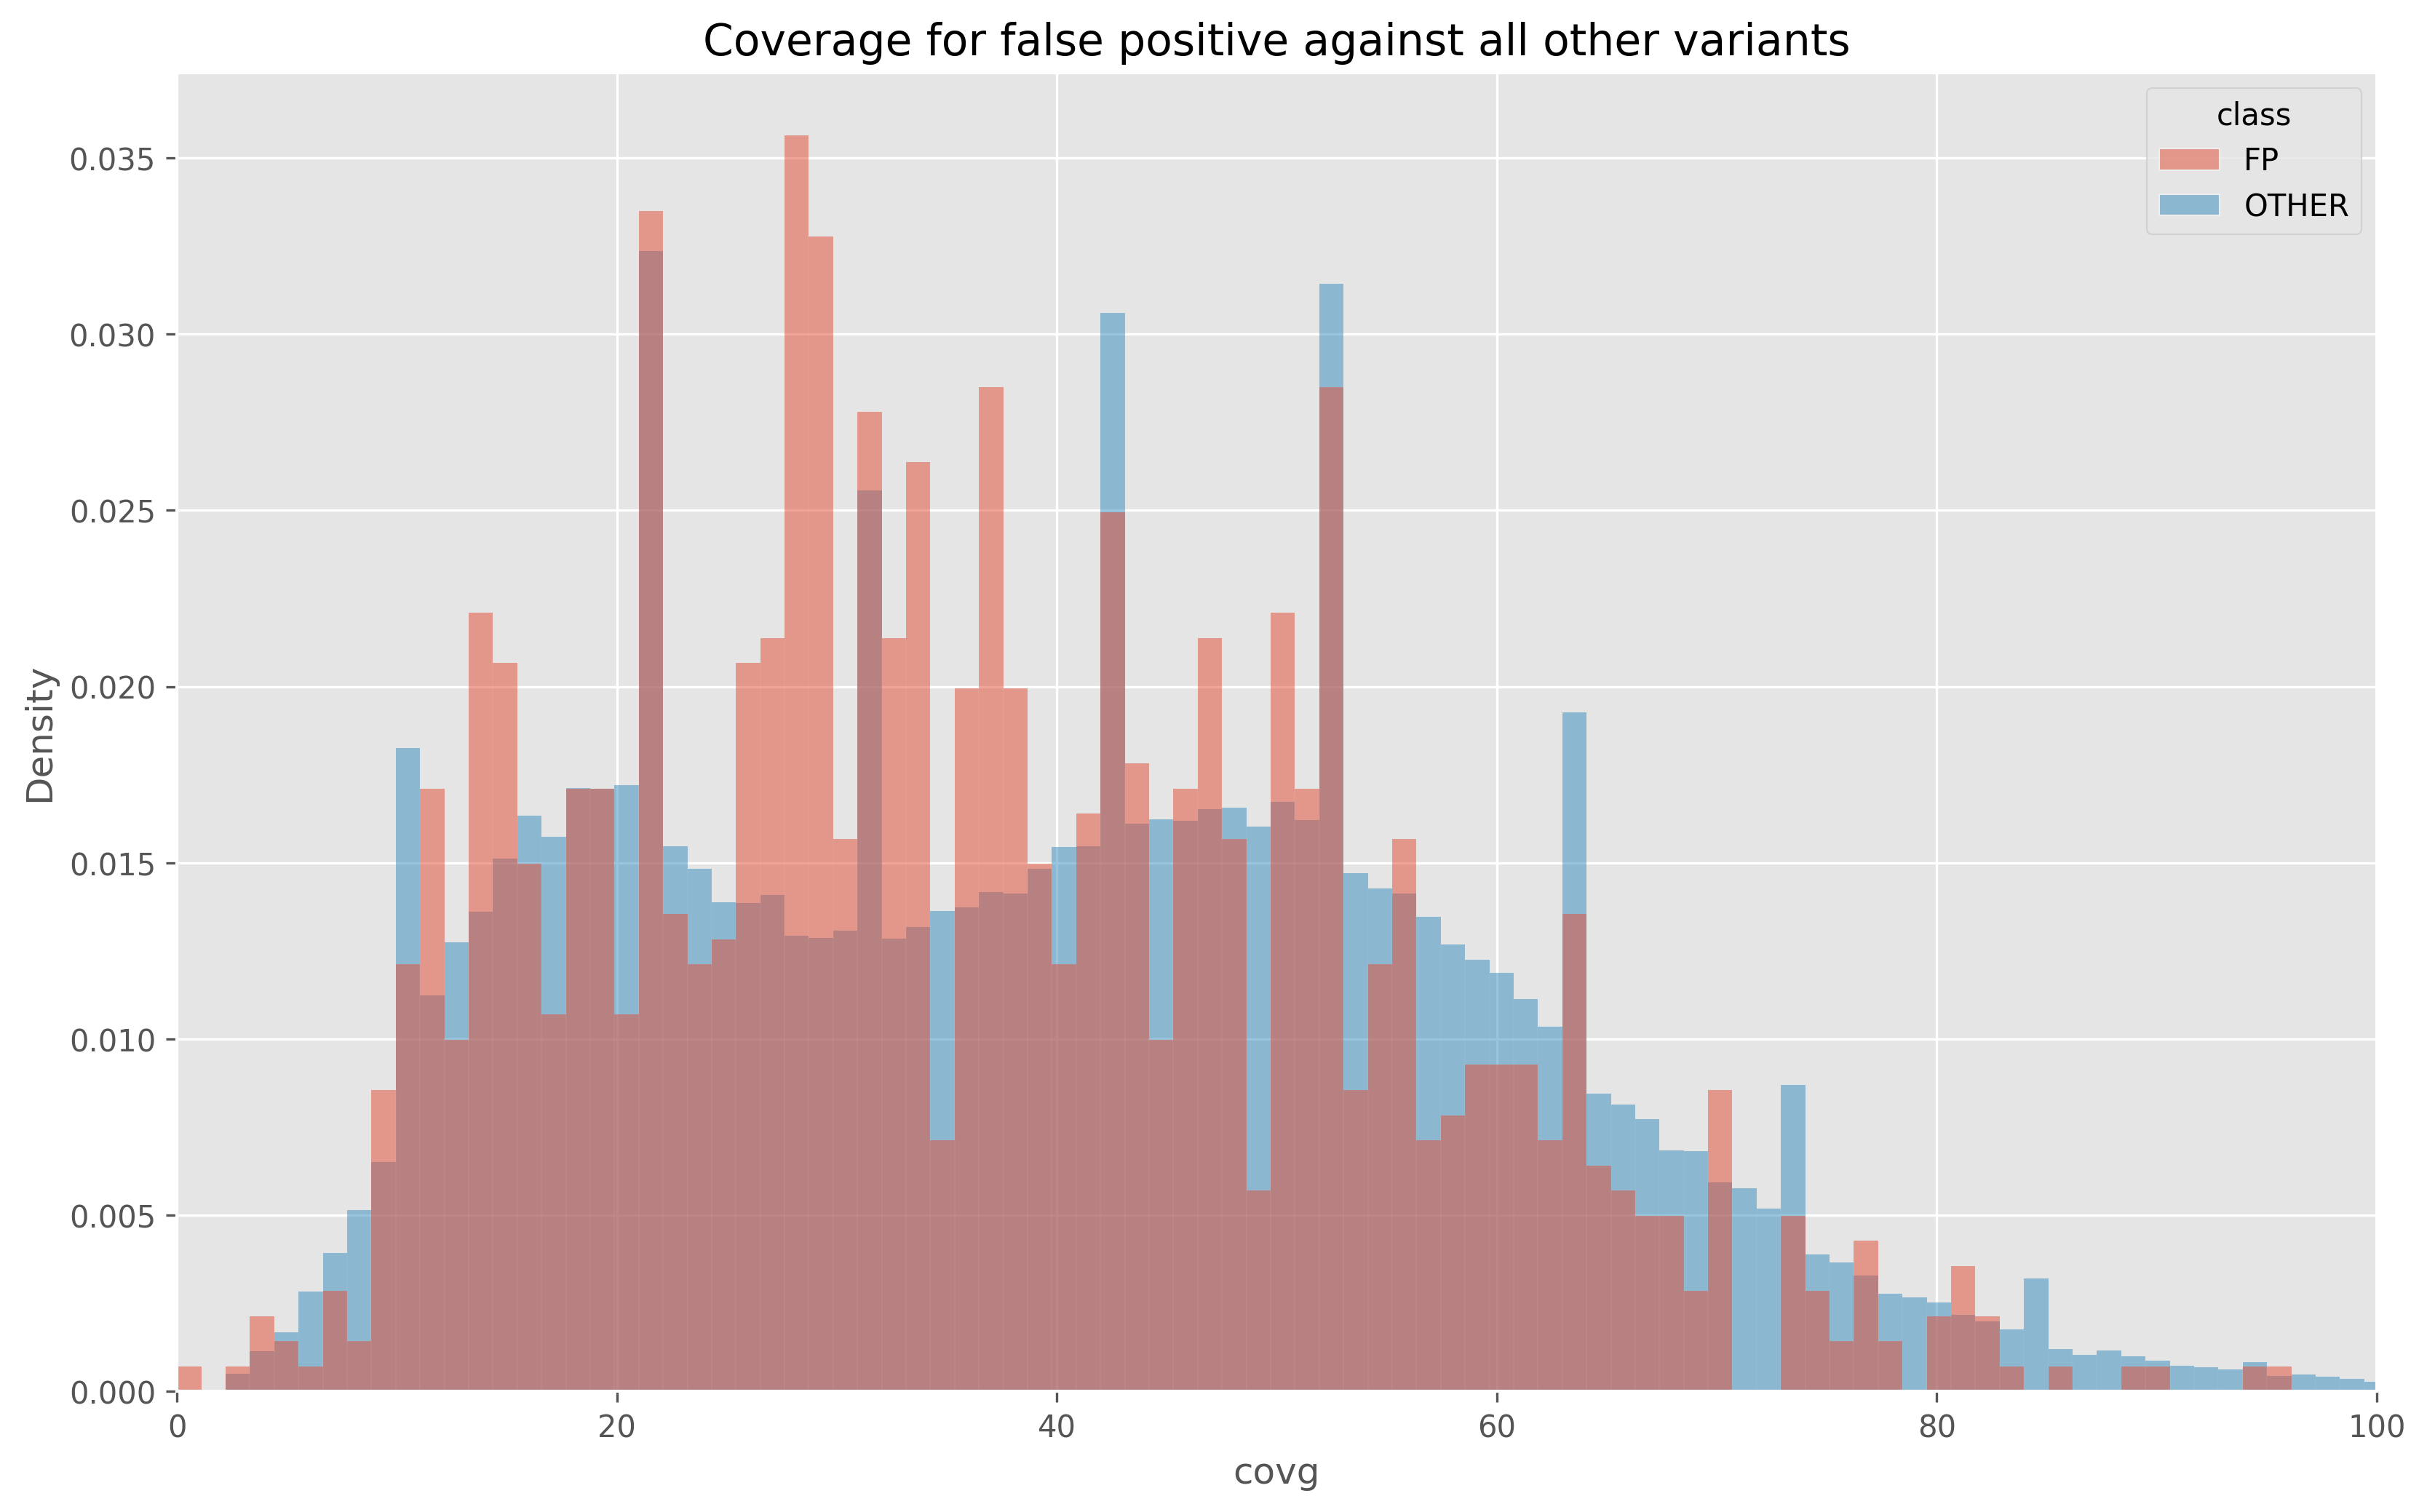

In [46]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=covg_df, x="covg", hue="class", common_norm=False, stat="density")
ax.set_xlim((0, 100))
# ax.set_ylim((0, 2000))
_ = ax.set(title="Coverage for false positive against all other variants")

In [47]:
covg_df.groupby("class").describe()

covg                                                     
          count       mean        std  min   25%   50%   75%     max
class                                                               
FP       1270.0  37.087402  17.273476  0.0  24.0  36.0  50.0   105.0
OTHER  158774.0  40.802480  27.212510  3.0  24.0  40.0  54.0  4235.0

Looking at strand bias info

In [48]:
def get_bias(variant: Variant, sample_idx: int = 0) -> float:
    strand = Strand.from_variant(variant, sample_idx=sample_idx)
    return strand.ratio

In [49]:
strand_data = []
for i in range(len(pandora_fp_bases)):
    _, _, pos, sample = pandora_fp_bases[i]
    region = f"{chrom}:{pos}-{pos}"
    rv = next(pandora_refvcf(region), None)
    vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
    v = next(vcf(region), None)
    if v is None:
        strand_data.append((get_bias(rv), "FP"))
        continue
    if rv is None:
        strand_data.append((get_bias(v), "FP"))
        continue
    strand_data.append((get_bias(rv), "FP"))
    strand_data.append((get_bias(v), "FP"))
    
for sample in pandora_diff_positions:
    for variant in VCF(f"pandora/{sample}.snps.filtered.bcf"):
        if variant.POS in fp_poss or variant.FILTER:
            continue
        strand_data.append((get_bias(variant), "OTHER"))
for variant in VCF(f"pandora/{REF}.snps.filtered.bcf"):
    if variant.POS in fp_poss or variant.FILTER:
        continue
    strand_data.append((get_bias(variant), "OTHER"))
    
strand_df = pd.DataFrame(strand_data, columns=["bias", "class"])

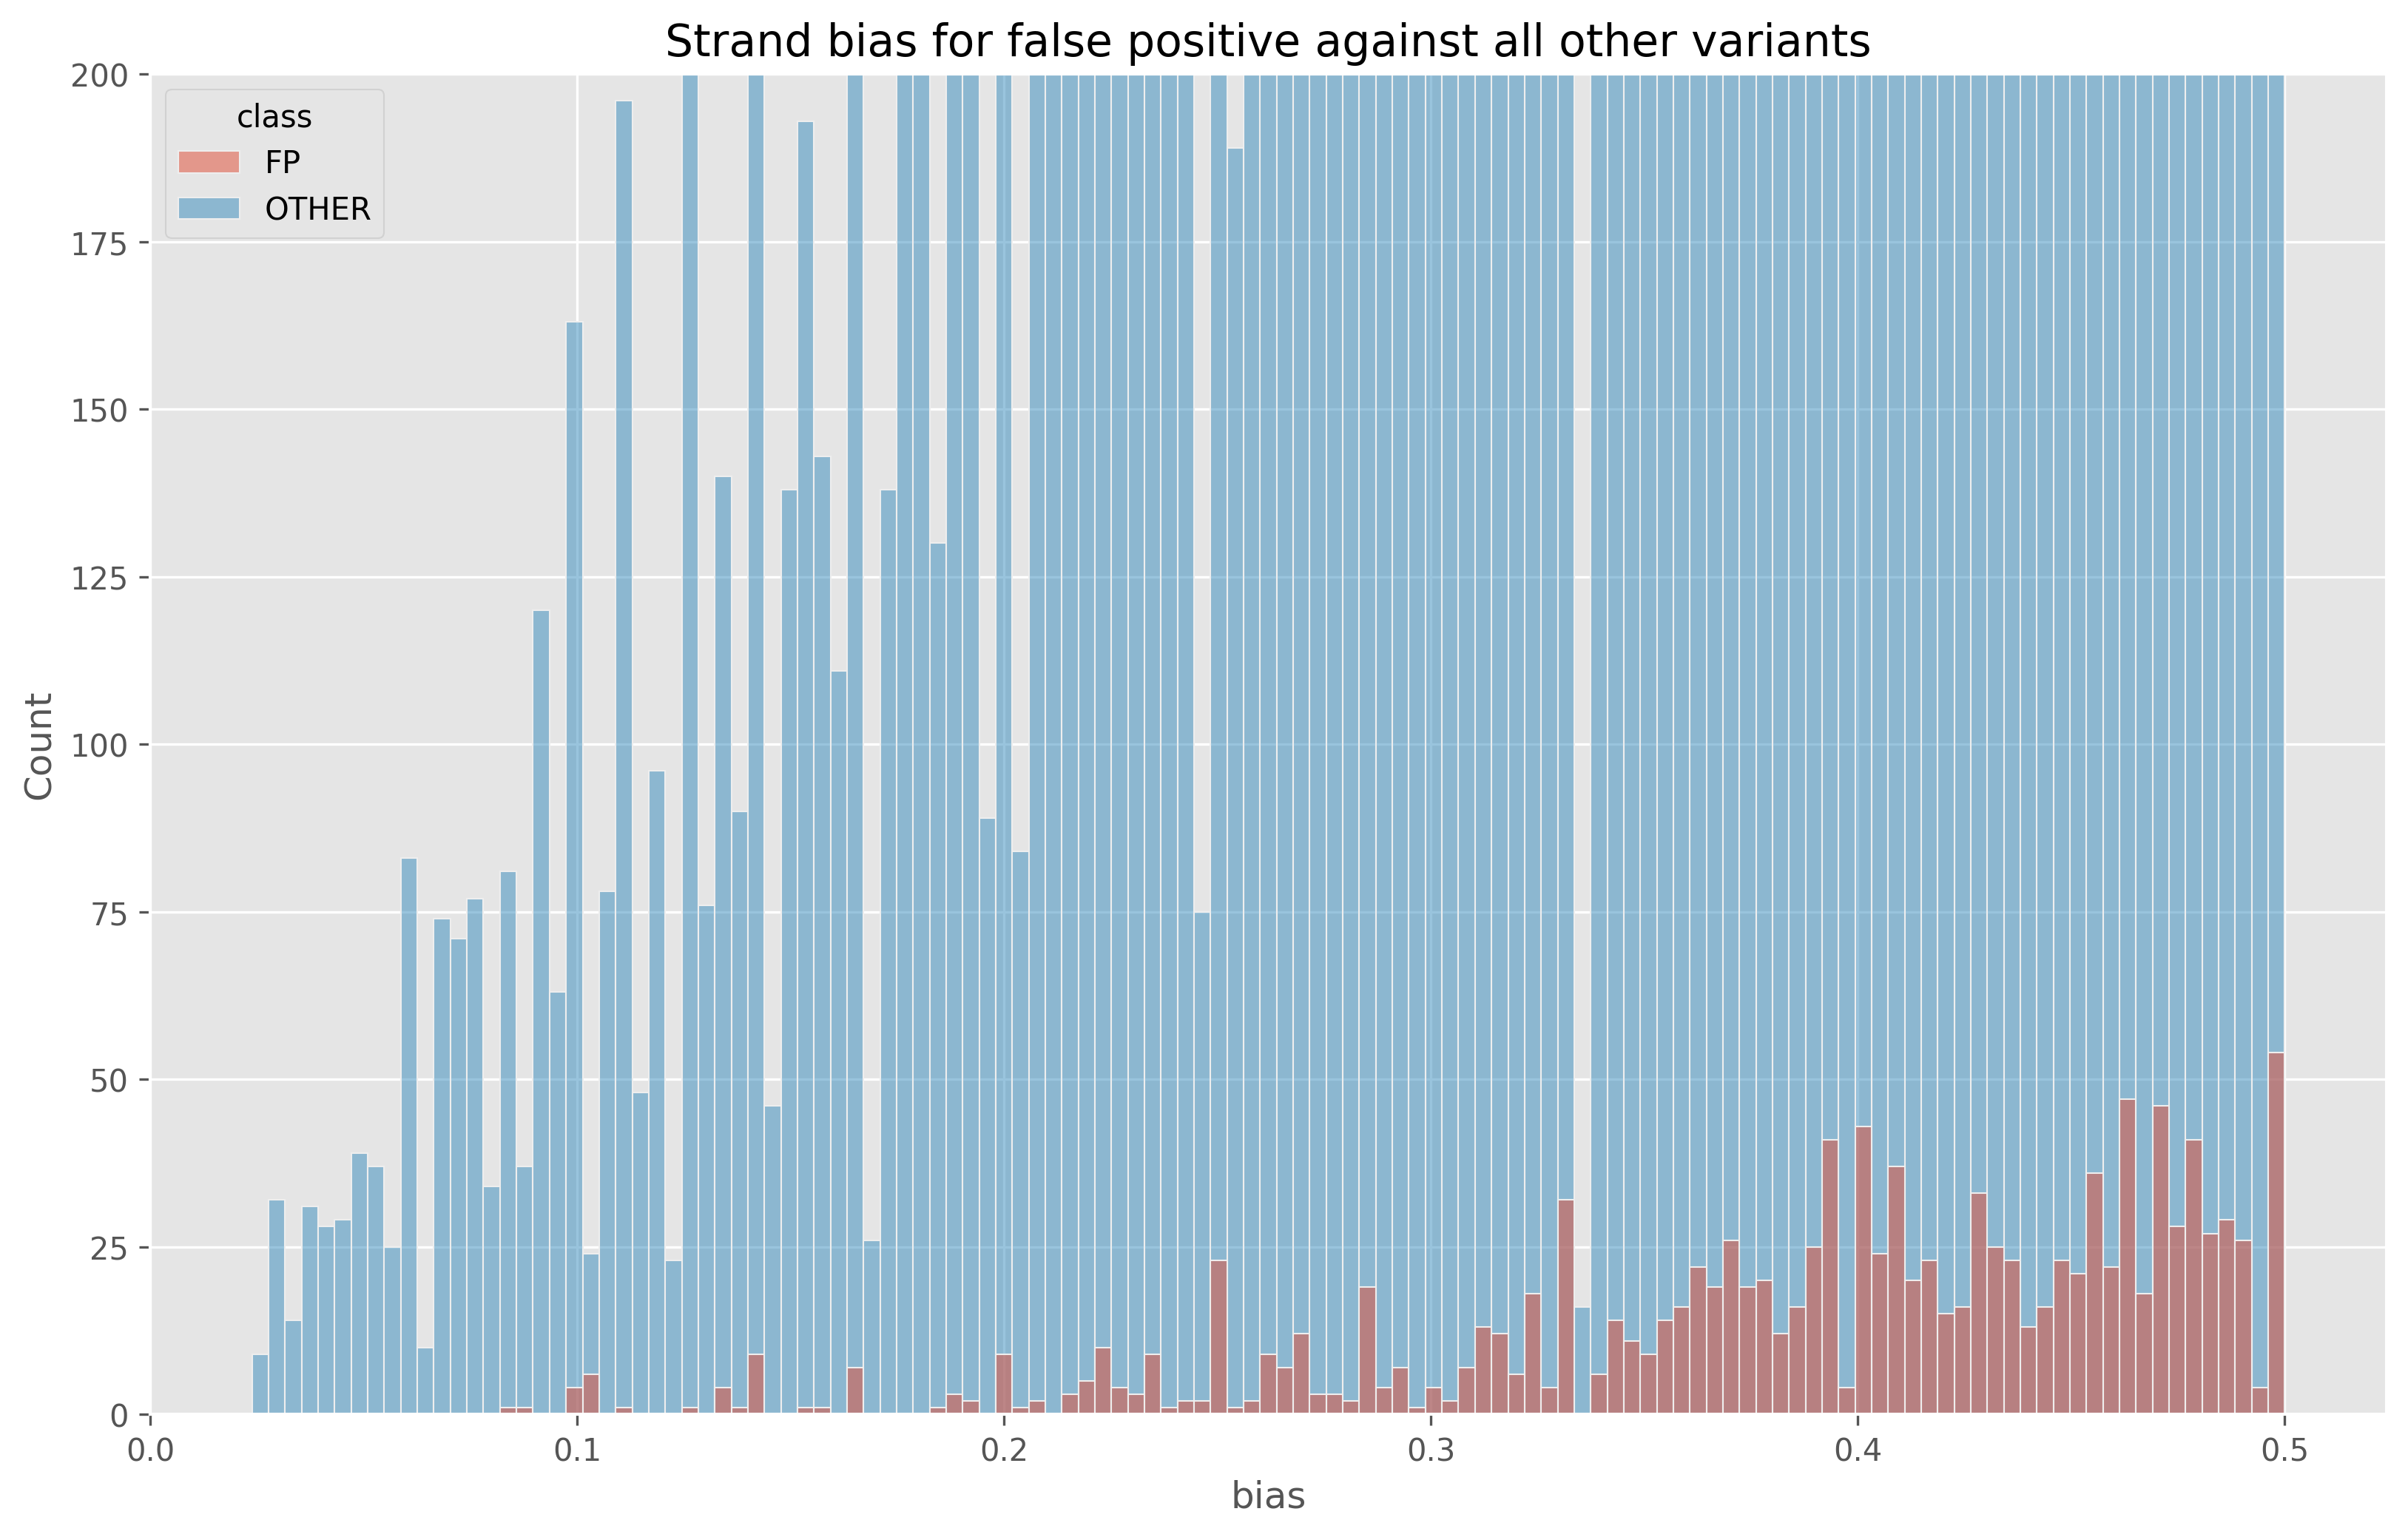

In [50]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=strand_df, x="bias", hue="class", )
# sns.histplot(data=strand_df, x="bias", hue="class", common_norm=False, stat="density")
# ax.set_xlim((0, 100))
ax.set_ylim((0, 200))
_ = ax.set(title="Strand bias for false positive against all other variants")

Ok, let's see whether filtering based on FRS improves the situation (i.e. reduce FPs without losing too many TPs).

Say the coverage on the called/genotyped allele is $c$, and the total coverage across all alleles is $C$.
Then FRS - fraction of read support - is $\frac{c}{C}$. ie what % of reads support the called allele.

In [70]:
def frs(variant: Variant, sample_idx: int = 0) -> float:
    fwd_covgs = variant.format(Tags.FwdCovg.value)[sample_idx]
    rev_covgs = variant.format(Tags.RevCovg.value)[sample_idx]
    total_covg = sum(fwd_covgs) + sum(rev_covgs)
    called_idx = Genotype.from_arr(variant.genotypes[sample_idx]).allele_index()
    called_covg = fwd_covgs[called_idx] + rev_covgs[called_idx]
    try:
        return called_covg / total_covg
    except ZeroDivisionError:
        return 1.0
p = 57298
v = next(pandora_refvcf(f"{chrom}:{p}-{p}"))
actual = frs(v)
assert actual == (30/46)

In [147]:
xs = []
thresholds = list(np.arange(0.5, 0.95, 0.05))
thresholds.extend(np.arange(0.91, 1.01, 0.01))
for frs_threshold in thresholds:
    frs_threshold = round(frs_threshold, 2)
    num_fp_filtered = 0
    for _, row in fp_df.iterrows():
        pos = row["pos"]
        sample = row["sample"]
        region = f"{chrom}:{pos}-{pos}"
        rv = next(pandora_refvcf(region), None)
        vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
        v = next(vcf(region), None)
        if v is None:
            support = frs(rv)
        elif rv is None:
            support = frs(v)
        else:
            support = min(frs(v), frs(rv))
        if support <= frs_threshold:
            num_fp_filtered += 1

    print(f"{num_fp_filtered}/{len(fp_df)} ({num_fp_filtered/len(fp_df):.2%}) FPs would be filtered with an FRS threshold of {frs_threshold}")

    tp_df = df.query("classification == 'TP'")

    num_tp_filtered = 0
    for _, row in tp_df.iterrows():
        pos = row["pos"]
        sample = row["sample"]
        region = f"{chrom}:{pos}-{pos}"
        rv = next(pandora_refvcf(region), None)
        vcf = VCF(f"pandora/{sample}.snps.filtered.bcf")
        v = next(vcf(region), None)
        if v is None:
            support = frs(rv)
        elif rv is None:
            support = frs(v)
        else:
            support = min(frs(v), frs(rv))
        if support <= frs_threshold:
            num_tp_filtered += 1

    print(f"{num_tp_filtered}/{len(tp_df)} ({num_tp_filtered/len(tp_df):.2%}) TPs would be filtered with an FRS threshold of {frs_threshold}")
    xs.append((num_tp_filtered/len(tp_df), num_fp_filtered/len(fp_df), frs_threshold))
#     xs.append((num_tp_filtered, num_fp_filtered, frs_threshold))

3/883 (0.34%) FPs would be filtered with an FRS threshold of 0.5
0/41 (0.00%) TPs would be filtered with an FRS threshold of 0.5
6/883 (0.68%) FPs would be filtered with an FRS threshold of 0.55
1/41 (2.44%) TPs would be filtered with an FRS threshold of 0.55
15/883 (1.70%) FPs would be filtered with an FRS threshold of 0.6
1/41 (2.44%) TPs would be filtered with an FRS threshold of 0.6
49/883 (5.55%) FPs would be filtered with an FRS threshold of 0.65
2/41 (4.88%) TPs would be filtered with an FRS threshold of 0.65
81/883 (9.17%) FPs would be filtered with an FRS threshold of 0.7
5/41 (12.20%) TPs would be filtered with an FRS threshold of 0.7
168/883 (19.03%) FPs would be filtered with an FRS threshold of 0.75
5/41 (12.20%) TPs would be filtered with an FRS threshold of 0.75
230/883 (26.05%) FPs would be filtered with an FRS threshold of 0.8
5/41 (12.20%) TPs would be filtered with an FRS threshold of 0.8
287/883 (32.50%) FPs would be filtered with an FRS threshold of 0.85
6/41 (14.6

In [148]:
filtdf = pd.DataFrame(xs, columns=["TP", "FP", "FRS"]).melt(id_vars="FRS", var_name="class", value_name="filtered")

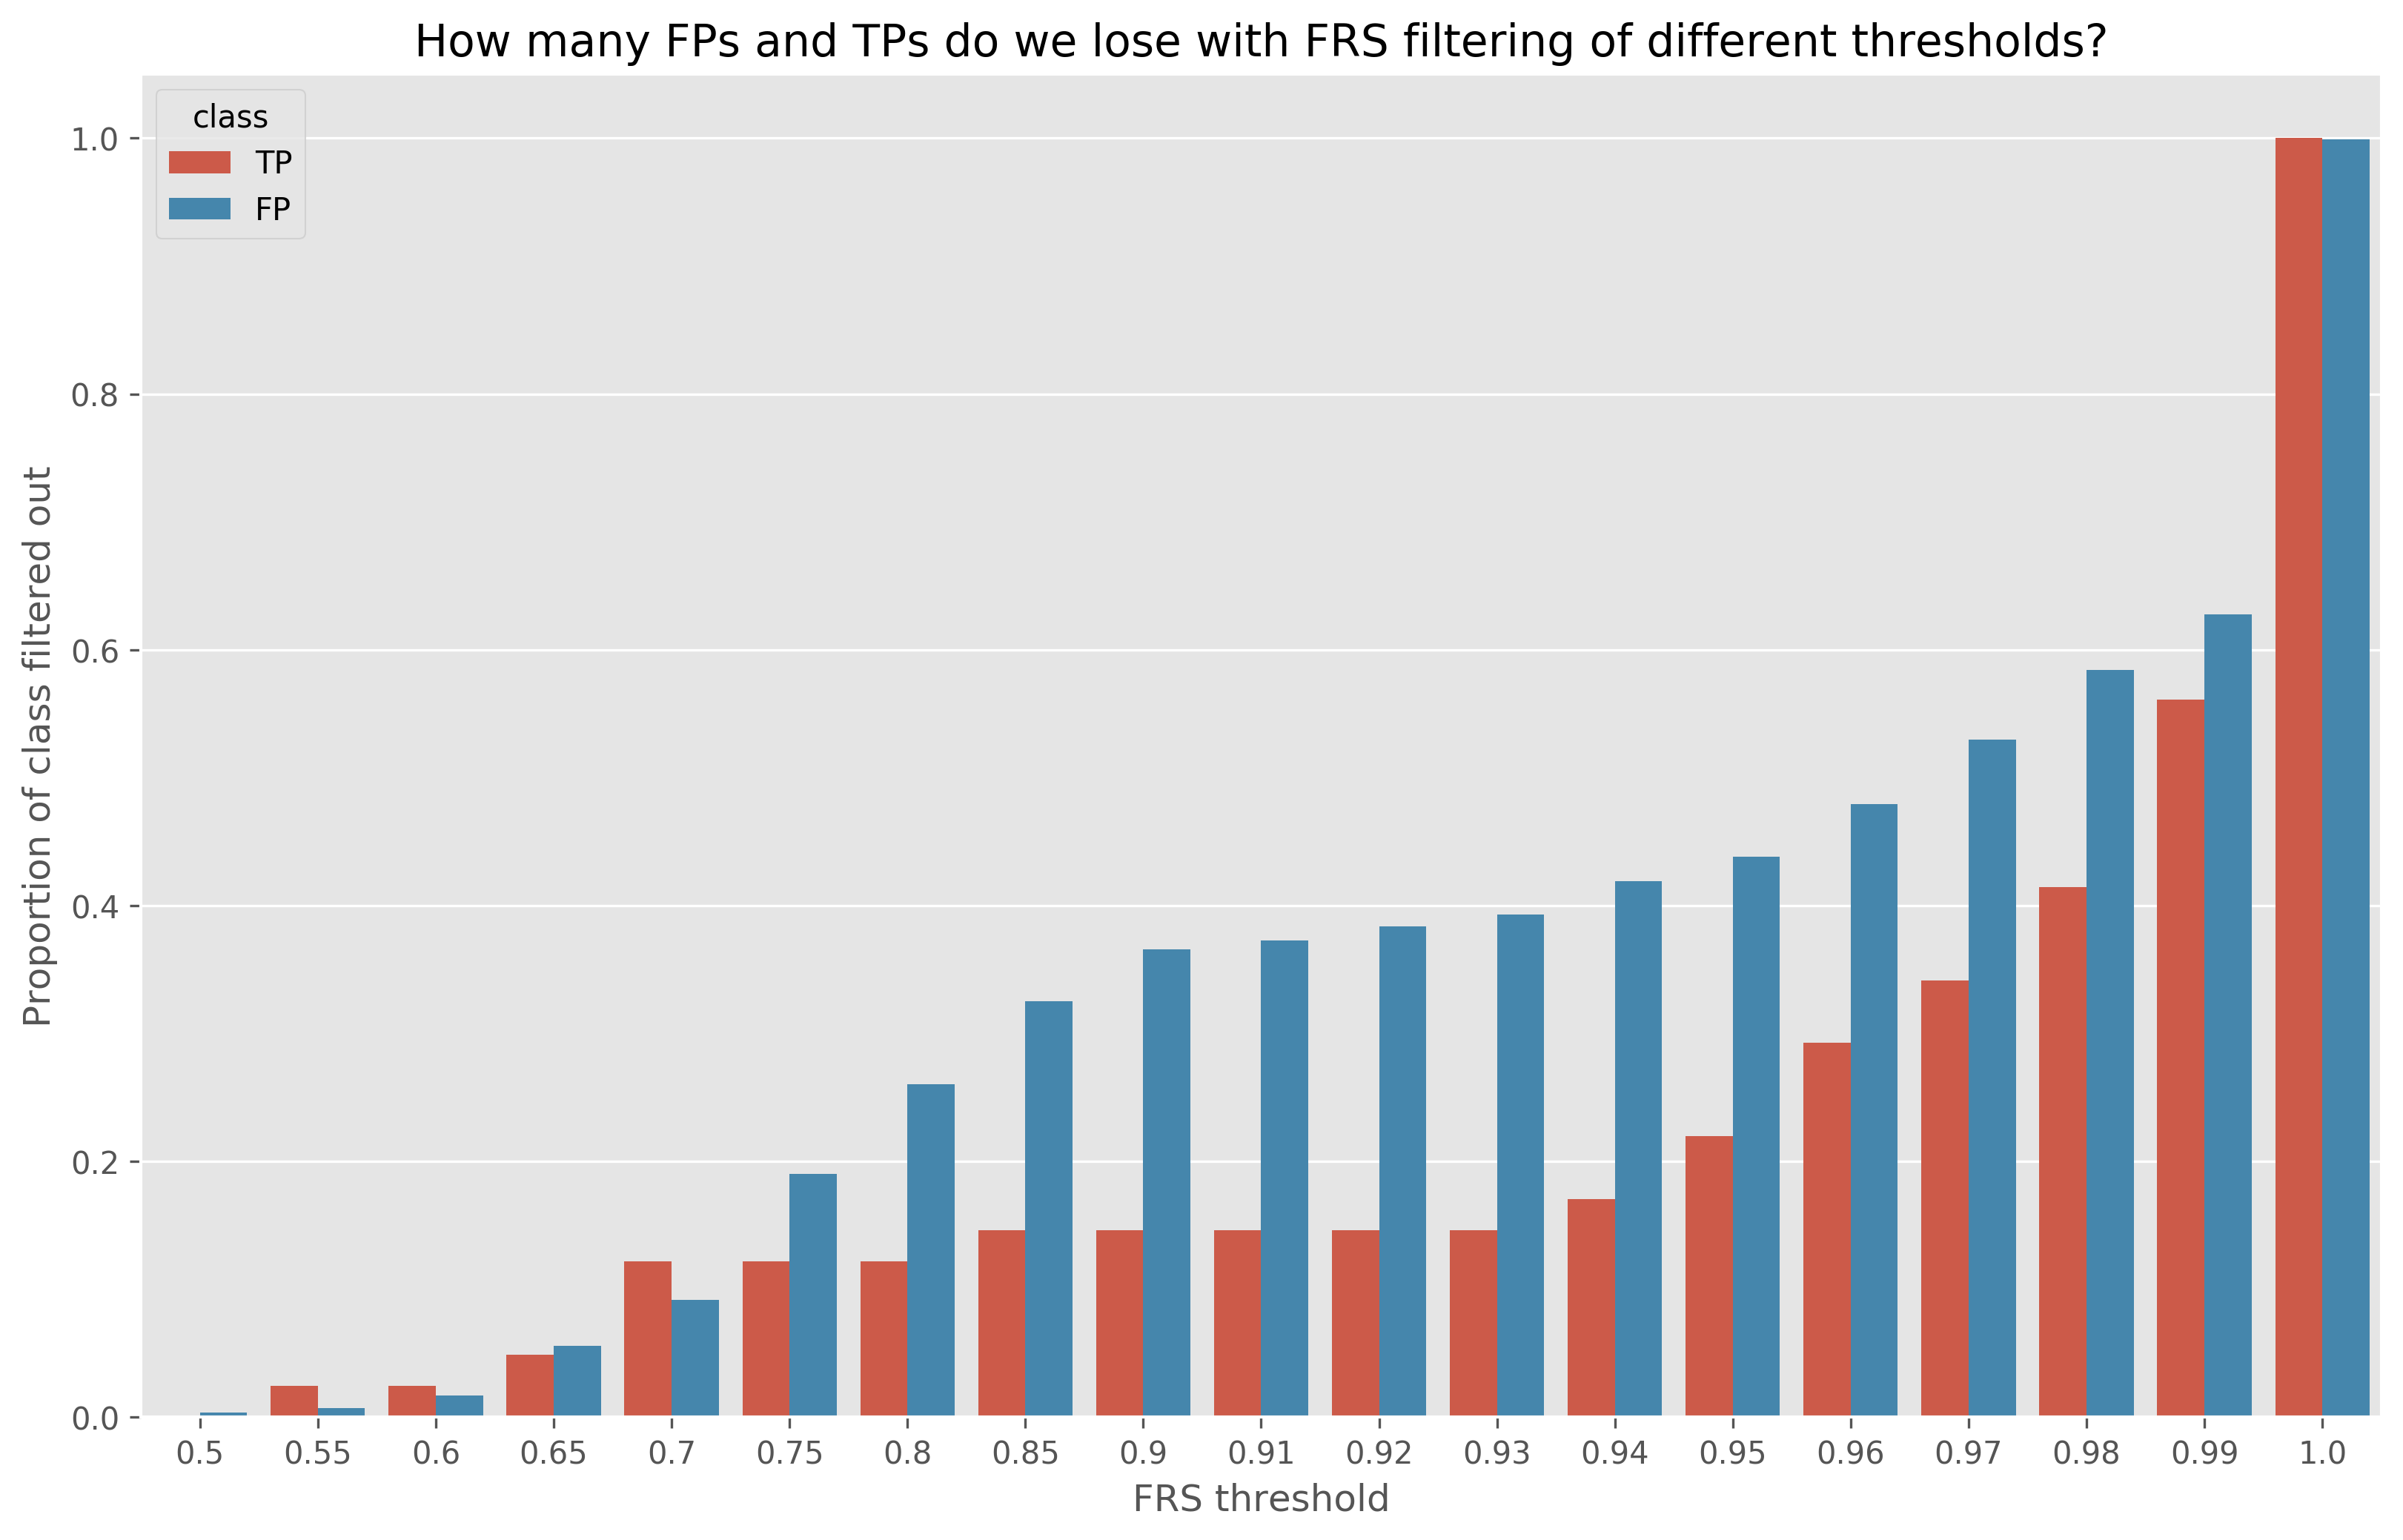

In [149]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.barplot(data=filtdf,x="FRS", y="filtered", hue="class", )
# sns.histplot(data=strand_df, x="bias", hue="class", common_norm=False, stat="density")
# ax.set_xlim((0, 100))
# ax.set_ylim((0, 200))
_ = ax.set(title="How many FPs and TPs do we lose with FRS filtering of different thresholds?", 
           ylabel="Proportion of class filtered out",
          xlabel="FRS threshold")

In [113]:
filtdf = pd.DataFrame(xs, columns=["TP", "FP", "threshold"])

In [116]:
filtdf.melt(id_vars="threshold", var_name="class", value_name="FRS")

,threshold,class,FRS
0,0.50,TP,0.000000
1,0.55,TP,0.024390
2,0.60,TP,0.024390
3,0.65,TP,0.048780
4,0.70,TP,0.097561
5,0.75,TP,0.121951
6,0.80,TP,0.121951
7,0.85,TP,0.146341
8,0.90,TP,0.146341
9,0.95,TP,0.195122


In [151]:
0.9*(1-0.11)

0.801